In [171]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import yfinance as yf
import os
sys.path.append(os.getcwd() + '/modules')
import seaborn as sns

from modules.directional_change import get_data, get_DC_data, get_DC_data_v2, get_TMV, get_T, get_R
from modules.hidden_markov_model import fit_hmm, standardize_regime_labels, make_regime_plots
from modules.trading_strategy import get_metrics, RSI

plt.style.use('seaborn')
sns.set_theme()

In [174]:
df = yf.download("^GSPC", start="2012-01-01", end="2021-12-31")['Adj Close']
get_metrics(df.pct_change().dropna())

[*********************100%***********************]  1 of 1 completed


,pnl,sharpe,sortino,volatility,mdd
,2.74,0.89,0.83,0.0103,-0.382495


In [175]:
rsi = RSI(df,lookback=5)
pos = rsi.apply(lambda x: -1 if x>70 else (1 if x<30 else 0))
pnl = (pos*df.pct_change()).dropna()
get_metrics(pnl)

,pnl,sharpe,sortino,volatility,mdd
,0.49,0.44,0.31,0.0064,-0.160757


[*********************100%***********************]  2 of 2 completed
Total duration of time: 566438400.0
Total duration spent in Regime 2: 463178700.0
Proportion of time spent in Regime 2: 0.8177035667073419
Flipping labels between regimes.


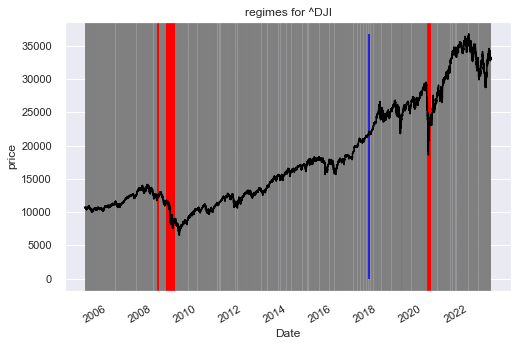

Total duration of time: 566784000.0
Total duration spent in Regime 2: 550627200.0
Proportion of time spent in Regime 2: 0.9714939024390243
Flipping labels between regimes.


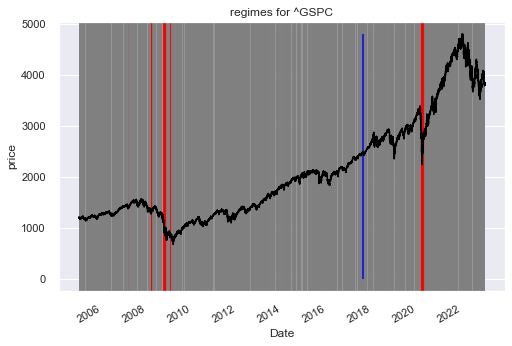

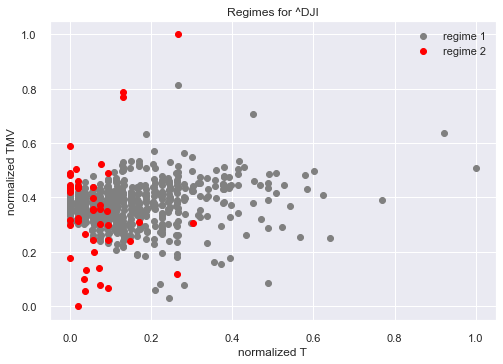

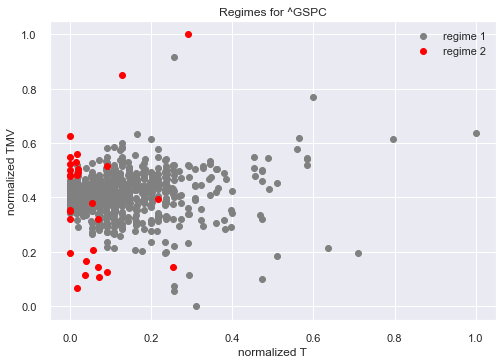

In [253]:
"""Pipeline"""

"""Hyperparameters"""

TYPE = 'equity' # 'equity' or 'fx' or 'bond'

TICKER_MAPPER = {'equity':['^DJI','^GSPC'],
                'bond':['^TNX', '^IRX'],
                'fx':['RUB=X','GBP=X']}

TICKERS = TICKER_MAPPER[TYPE]
START_DATE = "2005-01-01"
THETA = 0.0025
NUM_REGIMES = 2

TRADING_DAY = {'equity':6.5, 'fx':12,'bond':9} # number of hours in a day we offset
TEST_TICKER = TICKERS[-1] # if we need to debug for a single ticker

df_ts = get_data(TICKERS, START_DATE, TRADING_DAY[TYPE]/2)
df_ret = df_ts.pct_change().dropna()

DC = {}
for ticker in TICKERS:
    DC[ticker] = get_DC_data(df_ts[ticker], THETA)

tmv = {}
T = {}
R = {}
for ticker in TICKERS:
    tmv[ticker] = get_TMV(DC[ticker],THETA)
    T[ticker] = get_T(DC[ticker])
    R[ticker] = get_R(tmv[ticker],T[ticker],THETA)

regimes = {}
for ticker in TICKERS:
    regime, model = fit_hmm(NUM_REGIMES, df_ts[ticker], R[ticker], ticker, plot = True)
    regimes[ticker] = regime
    
for ticker in TICKERS:
    make_regime_plots(regimes[ticker], tmv[ticker], T[ticker],ticker)